In [1]:
import sys
sys.path.append("..")

from qdhmc import HMC
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-07-18 15:02:49.235994: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-18 15:02:49.236035: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-07-18 15:02:52.658035: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-18 15:02:52.658169: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-18 15:02:52.658225: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcub

In [2]:
def guassian_log_prob(n, temp):
    def lp(x):
        return np.sum([-1 * x[i] for i in range(n)] + [-1 * x[i]**2 for i in range(n)])/temp
    return lp

def plot_guassian_lp(temp):
    def lp(x):
        return np.sum(-x - x**2, axis=1)/temp
    return lp

def sphere_log_prob(n, temp):
    def lp(x):
        return -1 * np.sum([x[i]**2 for i in range(n)])/temp
    return lp

def plot_sphere_log_prob(n, temp):
    def lp(x):
        return -1 * np.sum(x**2, axis=1)/temp
    return lp

def double_well_log_prob(temp):
    def lp(x):
        return (-1*(x[0]**4 - 4 * x[0]**2 + x[1]**2) - 0.5 * x[0])/temp
    return lp

def plot_double_well(temp):
    def lp(x):
        return (-1*(x[:,0]**4 - 4 * x[:,0]**2 + x[:,1]**2) - 0.5 * x[:,0])/temp
    return lp

def well_log_prob(temp):
    def lp(x):
        return (-1*(x[0]**4 - 4 * x[0]**2) - 0.5 * x[0])/temp
    return lp

def plot_well(temp):
    def lp(x):
        return (-1*(x[:,0]**4 - 4 * x[:,0]**2) - 0.5 * x[:,0])/temp
    return lp


In [3]:
# HYPERPARAMETERS

t = 1.0
rep = 3
precision = 6
n = 1
opt_len = 20
temperature = 1

In [4]:
#log_prob = guassian_log_prob(n, temperature)
#log_prob = sphere_log_prob(n, temperature)
#log_prob = double_well_log_prob(temperature)
log_prob = well_log_prob(temperature)

#plot_lp = plot_sphere_log_prob(n, temperature)
#plot_lp = plot_double_well(temperature)
plt_lp = plot_well(temperature)
#plot_lp = plot_guassian_lp(temperature)

test_c = HMC(log_prob, kernel_type='classical', num_vars=n, precision=precision, step_size=0.3)
test_q = HMC(log_prob, kernel_type='quantum', precision=precision, r=rep, num_vars=n, t=t)

In [5]:
tf.random.set_seed(42)
np.random.seed(42)
init_state = tf.random.uniform(shape=[n], minval=-tf.math.sqrt(2 * np.pi * 2 ** precision) / 4, \
                                        maxval=tf.math.sqrt(2 * np.pi * 2 ** precision) / 4)
#init_state = tf.convert_to_tensor([2.0, 0.0])
#init_state = tf.convert_to_tensor([7.0, -10.0])

s, m, std, a, rs = test_c.run_hmc(opt_len, 0, init_state=init_state)
s_q, m_q, std_q, a_q, rs_q = test_q.run_hmc(opt_len, 0, init_state=init_state)

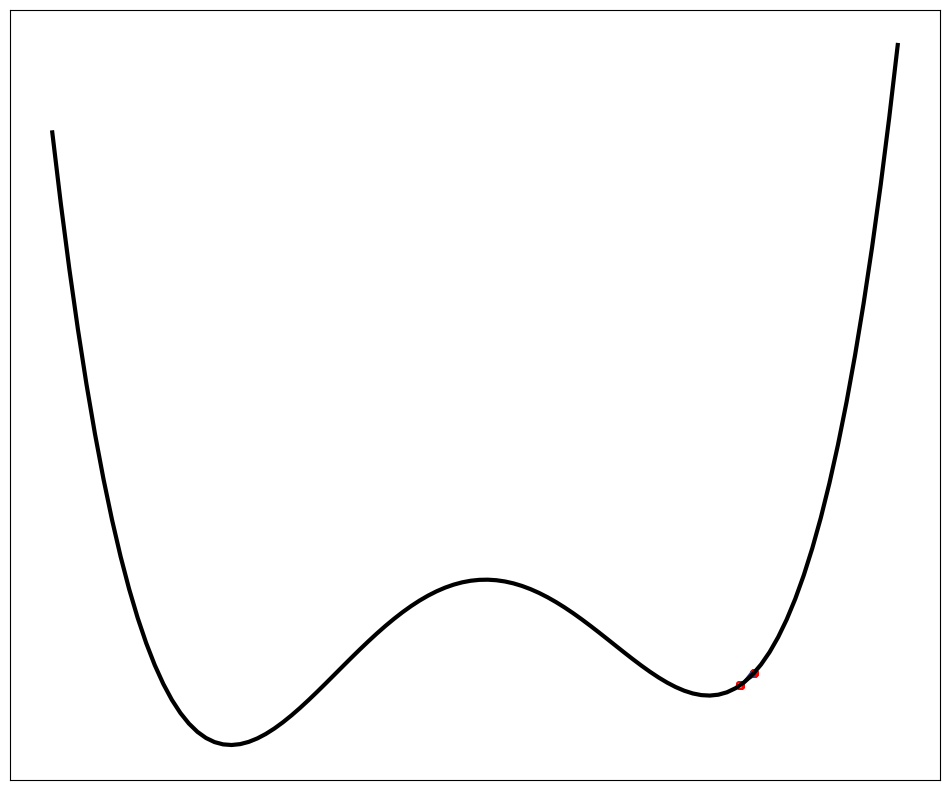

In [6]:
if n == 1:
    edge = min(min(min(s), init_state), -max(max(s), init_state))
    edge = -1.5
    xs = np.linspace(edge - 1, -edge + 1, 100).reshape(100, 1)
    ys = [-log_prob(i) for i in xs]
    
    plt.figure(figsize=(12, 10))
    plt.xticks([])
    plt.yticks([])
    path = np.asarray([[init_state.numpy()[0], -log_prob(init_state)]] + [[i.numpy()[0], -log_prob(i)] for i in s_q]).T
    plt.plot(xs, ys, color='black', linewidth=3)
    plt.scatter(path[0], path[1], color='red', s=30)
    plt.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], [i for i in range(opt_len)], \
               scale_units='xy', angles='xy', scale=1, color='k', headwidth=2.0, linewidth=3, width=0.005)

    plt.show()
elif n == 2:
    edge = min(min(np.min(s_q), np.min(init_state)), -max(np.max(s_q), np.max(init_state)))
    xs = np.linspace(edge - 1, -edge + 1, 40)
    ys = np.linspace(edge - 1, -edge + 1, 40)

    X, Y = np.meshgrid(xs, ys)
    Z = np.asarray([plot_lp(np.stack(xy, axis=1)) for xy in zip(X, Y)])

    path = np.asarray([[init_state.numpy()[0], init_state.numpy()[1], log_prob(init_state)]] + \
                      [[i.numpy()[0], i.numpy()[1], log_prob(i)] for i in s]).T
    
    #fig = plt.figure(figsize=(12, 10))
    #ax = plt.axes(projection='3d')
    #ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    #plt.show()
    
    fig = plt.figure(figsize=(12, 10))
    path = np.asarray([init_state.numpy().tolist()] + s_q.numpy().tolist()).T
    #print(path)
    plt.contourf(X, Y, Z, 10, cmap='viridis')
    plt.scatter(path[0], path[1], color='red', s=20)
    plt.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], [i for i in range(opt_len)], \
               scale_units='xy', angles='xy', scale=1, cmap='inferno', headwidth=4.0, width=0.005)
    plt.show()

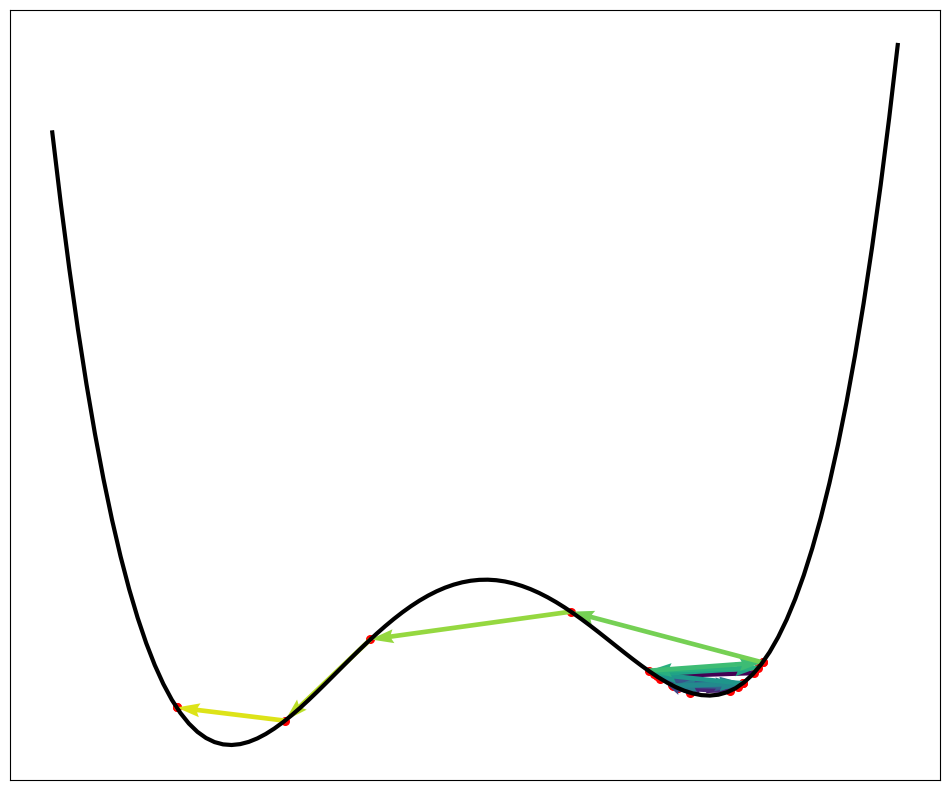

In [7]:
if n == 1:
    edge = min(min(min(s), init_state), -max(max(s), init_state))
    edge = -1.5
    xs = np.linspace(edge - 1, -edge + 1, 100).reshape(100, 1)
    ys = [-log_prob(i) for i in xs]

    plt.figure(figsize=(12, 10))
    plt.xticks([])
    plt.yticks([])
    path = np.asarray([[init_state.numpy()[0], -log_prob(init_state)]] + [[i.numpy()[0], -log_prob(i)] for i in s]).T
    plt.plot(xs, ys, color='black', linewidth=3)
    plt.scatter(path[0], path[1], color='red', s=30)
    plt.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], [i for i in range(opt_len)], \
               scale_units='xy', angles='xy', scale=1, color='k', headwidth=3.0, linewidth=3, width=0.005)

    plt.show()
elif n == 2:
    edge = min(min(np.min(s), np.min(init_state)), -max(np.max(s), np.max(init_state)))
    xs = np.linspace(edge - 1, -edge + 1, 40)
    ys = np.linspace(edge - 1, -edge + 1, 40)

    X, Y = np.meshgrid(xs, ys)
    Z = np.asarray([plot_lp(np.stack(xy, axis=1)) for xy in zip(X, Y)])

    path = np.asarray([[init_state.numpy()[0], init_state.numpy()[1], log_prob(init_state)]] + \
                      [[i.numpy()[0], i.numpy()[1], log_prob(i)] for i in s]).T
    
    #fig = plt.figure(figsize=(12, 10))
    #ax = plt.axes(projection='3d')
    #ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    #plt.show()
    
    fig = plt.figure(figsize=(12, 10))
    path = np.asarray([init_state.numpy().tolist()] + s.numpy().tolist()).T
    plt.contourf(X, Y, Z, 50, cmap='viridis')
    plt.scatter(path[0], path[1], color='red', s=20)
    plt.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], [i for i in range(opt_len)], \
               scale_units='xy', angles='xy', scale=1, cmap='inferno', headwidth=4.0, width=0.005)
    plt.show()

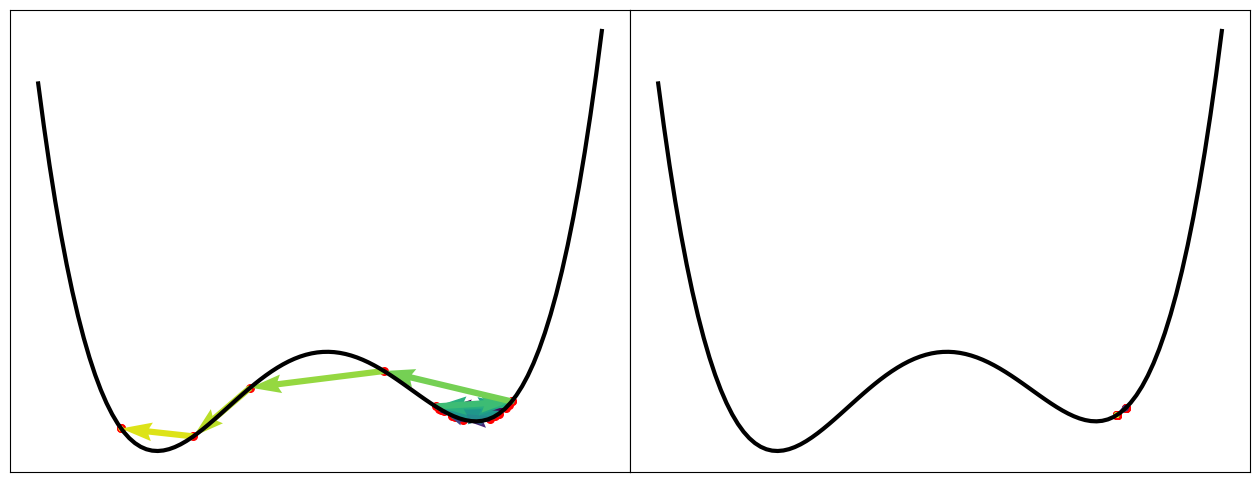

In [8]:
edge = -1.5
xs = np.linspace(edge - 1, -edge + 1, 100).reshape(100, 1)
ys = [-log_prob(i) for i in xs]

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].set_xticks([])
axs[1].set_yticks([])

path = np.asarray([[init_state.numpy()[0], -log_prob(init_state)]] + [[i.numpy()[0], -log_prob(i)] for i in s]).T
axs[0].plot(xs, ys, color='black', linewidth=3)
axs[0].scatter(path[0], path[1], color='red', s=30)
axs[0].quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], [i for i in range(opt_len)], \
           scale_units='xy', angles='xy', scale=1, color='k', headwidth=3.0, width=0.01)

path = np.asarray([[init_state.numpy()[0], -log_prob(init_state)]] + [[i.numpy()[0], -log_prob(i)] for i in s_q]).T
axs[1].plot(xs, ys, color='black', linewidth=3)
axs[1].scatter(path[0], path[1], color='red', s=30)
axs[1].quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], [i for i in range(opt_len)], \
           scale_units='xy', angles='xy', scale=1, color='k', headwidth=3.0,width=0.01)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()